In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from sklearn import decomposition

# Nettoyage et exploration

Chargement des datasets

In [96]:
df_customer = pd.read_csv('data/olist_customers_dataset.csv')
df_order_items = pd.read_csv('data/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
df_orders_init = pd.read_csv('data/olist_orders_dataset.csv')
df_products = pd.read_csv('data/olist_products_dataset.csv')

Travail sur la date de commande des produits

In [97]:
#Extraction de la date d'achat
df_orders_init['purchase_date'] = pd.to_datetime(df_orders_init['order_purchase_timestamp'].str.split(' ',expand=True)[0])

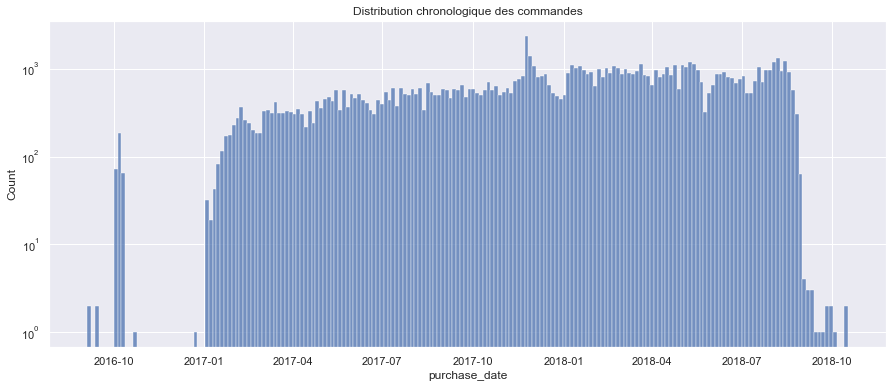

In [98]:
# Histogramme de la variable 'purchase_date'
sns.set(rc={'figure.figsize':(15,6)})
g = sns.histplot(data=df_orders_init, x='purchase_date', bins = 200);
g.set_yscale("log")
g.set(title='Distribution chronologique des commandes');

In [99]:
# Troncature des données pour enlever le début et la fin chronologique des données
df_orders = df_orders_init[(df_orders_init['purchase_date']>datetime.datetime(2017,2,1))&(df_orders_init['purchase_date']<datetime.datetime(2018,8,1))]

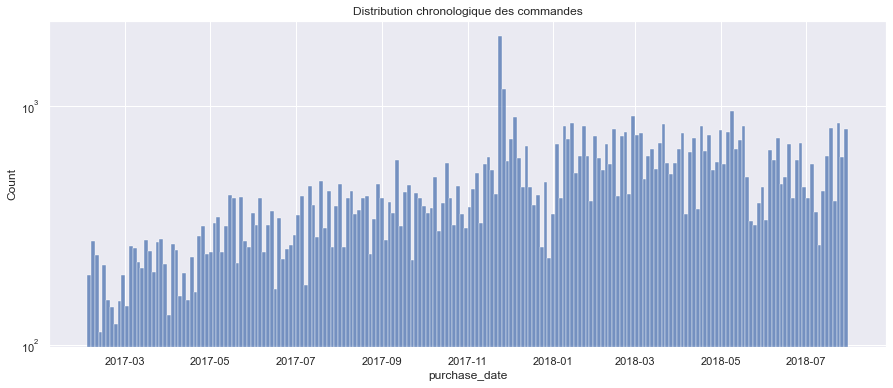

In [100]:
# Nouvelle visualisation de la variable
sns.set(rc={'figure.figsize':(15,6)})
g = sns.histplot(data=df_orders, 
                 x='purchase_date', bins = 200);
g.set_yscale("log")
g.set(title='Distribution chronologique des commandes');

In [101]:
# Affichage des jours avec le plus d'achats (Identification du Back Friday 2017)
df_orders['purchase_date'].value_counts().head(10)

2017-11-24    1176
2017-11-25     499
2017-11-27     403
2017-11-26     391
2017-11-28     380
2018-05-07     372
2018-05-14     364
2018-05-16     357
2018-05-15     352
2018-05-09     344
Name: purchase_date, dtype: int64

Travail sur le statut des commandes

In [102]:
#Dénombrement des commandes par statut
df_orders['order_status'].value_counts()

delivered      89049
shipped         1033
unavailable      579
canceled         492
processing       287
invoiced         260
created            5
approved           2
Name: order_status, dtype: int64

In [103]:
# Suppression des statuts autres que 'delivered'
df_orders = df_orders[df_orders['order_status']=='delivered']

Travail sur la valeur de la commande

In [104]:
# Regroupement des paiements par commande
data = df_order_payments.groupby(by='order_id',as_index = False).sum()[['order_id','payment_value']]
df_orders = df_orders.merge(data, on='order_id', how='left')

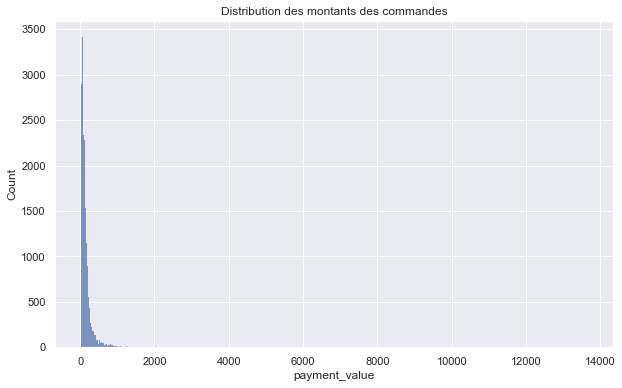

In [105]:
# Visualisation de la distribution des valeurs de paiement
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=df_orders, x='payment_value').set(title='Distribution des montants des commandes');

In [106]:
#Suppression des commandes supérieures à 1500
df_orders=df_orders[df_orders['payment_value']<1500].reset_index()

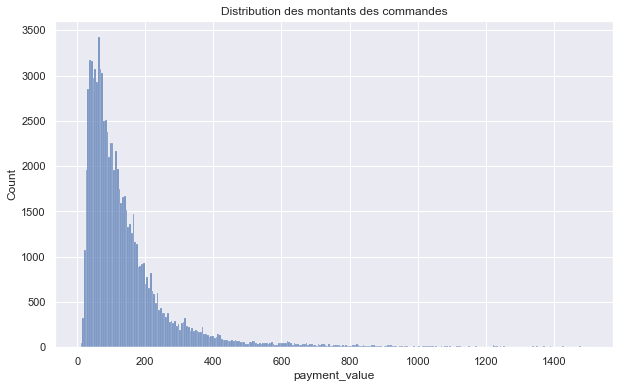

In [107]:
# Nouvelle visualisation de la variable
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data=df_orders, x='payment_value').set(title='Distribution des montants des commandes');

### Exploration des datasets

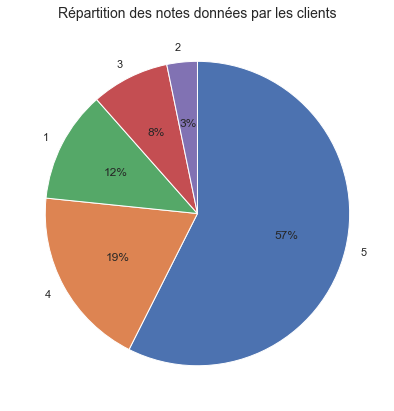

In [108]:
# Visualisation de la répartition des notes données par les clients
data = df_order_reviews['review_score'].value_counts()
fig,ax=plt.subplots(figsize=(7,7))
ax.pie(data,startangle=90,counterclock=False, labels = data.index, autopct='%1.0f%%')
plt.title('Répartition des notes données par les clients', size=14)
plt.show()

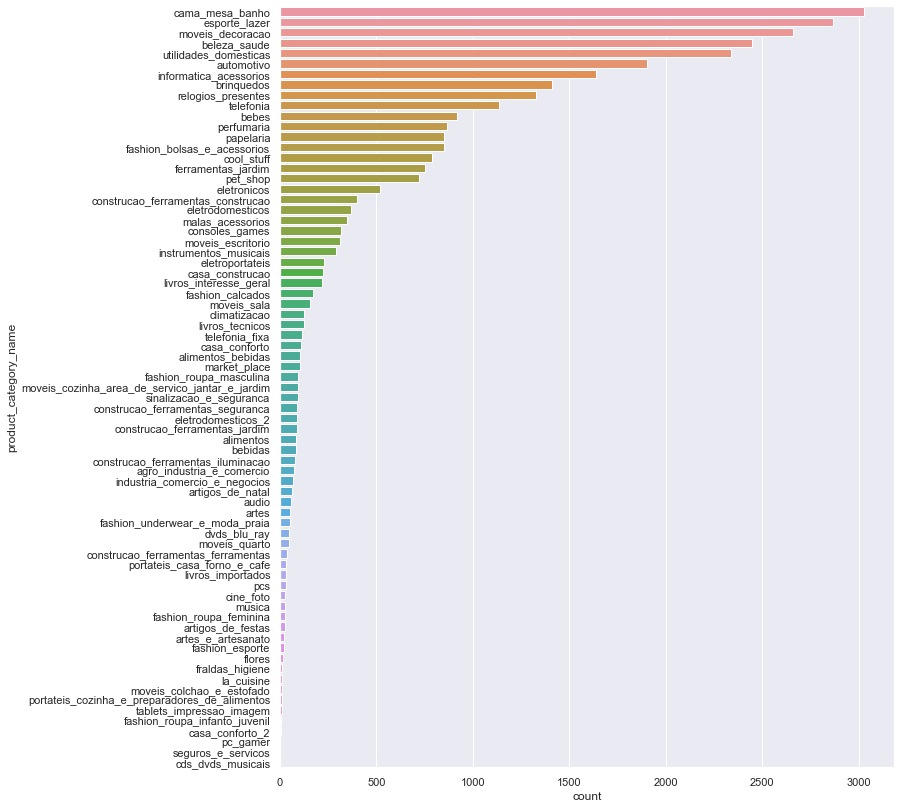

In [109]:
# Viualisation de la répartition par catégorie
sns.set(rc={'figure.figsize':(11,14)})
sns.countplot(data = df_products, y = 'product_category_name', 
              order = df_products['product_category_name'].value_counts().index);

### Mise en place des variable RFM

In [110]:
# ajout de la variable ID client unique
df_orders = df_orders.merge(df_customer[['customer_id','customer_unique_id']], how='left',on='customer_id')

In [111]:
# Calcul du nombre de jours depuis la commande
df_orders['purchased_x_days_ago'] = abs(df_orders['purchase_date']-df_orders['purchase_date'].max()).dt.days

Création du dataset pour segmentation manuelle

In [112]:
# Création de la variable F : Frequency
df_rfm = pd.DataFrame(df_orders['customer_unique_id'].value_counts()).reset_index(drop=False).rename(columns={'index':'customer_unique_id','customer_unique_id':'F'})

In [113]:
# Création de la variable R : Recency
data = df_orders[['customer_unique_id','purchased_x_days_ago']].groupby(by='customer_unique_id', as_index=False).min()
df_rfm = df_rfm.merge(data, on='customer_unique_id',how='outer').rename(columns={'purchased_x_days_ago':'R'})

In [114]:
# Création de la variable M : Monetary
data = df_orders[['customer_unique_id','payment_value']].groupby(by='customer_unique_id', as_index=False).sum()
df_rfm = df_rfm.merge(data, on='customer_unique_id',how='outer').rename(columns={'payment_value':'M'})

In [115]:
df_rfm = df_rfm[['customer_unique_id','R','F','M']]

In [116]:
df_rfm

,customer_unique_id,R,F,M
0,8d50f5eadf50201ccdcedfb9e2ac8455,8,12,709.77
1,3e43e6105506432c953e165fb2acf44c,154,9,1172.66
2,ca77025e7201e3b30c44b472ff346268,60,7,1122.72
3,1b6c7548a2a1f9037c1fd3ddfed95f33,167,7,959.01
4,6469f99c1f9dfae7733b25662e7f1782,33,7,758.83
...,...,...,...,...
85835,7f8198f8809d9091afbd1ad94aa2220c,20,1,83.56
85836,1e70248c64829f54e02845cc16e25638,326,1,81.11
85837,0781d2b5d775af55bd8995124c50fda6,250,1,55.11
85838,3a2681b8e4c9f2171aaade5d578f2cb7,79,1,264.37


In [117]:
# Calcul d'un score par variable RFM
df_rfm['Score R'] = pd.qcut(df_rfm['R'],5, labels = [5,4,3,2,1]).astype(str)

In [118]:
data = df_rfm['F']
conditions = [data==1,(data==2),(data==3),data==4,data>4]
values = [1,2,3,4,5]
df_rfm['Score F'] = np.select(conditions, values).astype(str)

In [119]:
df_rfm['Score M'] = pd.qcut(df_rfm['M'],5, labels = [1,2,3,4,5]).astype(str)

In [120]:
df_rfm['F'].value_counts()

1     83286
2      2354
3       160
4        23
5         9
7         3
6         3
12        1
9         1
Name: F, dtype: int64

In [121]:
# Création de la variable Score FM pour faciliter la segmentation
df_rfm['Score FM'] = (df_rfm['Score F'].astype('int') + df_rfm['Score M'].astype('int'))/2

In [122]:
df_rfm

,customer_unique_id,R,F,M,Score R,Score F,Score M,Score FM
0,8d50f5eadf50201ccdcedfb9e2ac8455,8,12,709.77,5,5,5,5.0
1,3e43e6105506432c953e165fb2acf44c,154,9,1172.66,4,5,5,5.0
2,ca77025e7201e3b30c44b472ff346268,60,7,1122.72,5,5,5,5.0
3,1b6c7548a2a1f9037c1fd3ddfed95f33,167,7,959.01,3,5,5,5.0
4,6469f99c1f9dfae7733b25662e7f1782,33,7,758.83,5,5,5,5.0
...,...,...,...,...,...,...,...,...
85835,7f8198f8809d9091afbd1ad94aa2220c,20,1,83.56,5,1,2,1.5
85836,1e70248c64829f54e02845cc16e25638,326,1,81.11,2,1,2,1.5
85837,0781d2b5d775af55bd8995124c50fda6,250,1,55.11,2,1,1,1.0
85838,3a2681b8e4c9f2171aaade5d578f2cb7,79,1,264.37,5,1,5,3.0


In [123]:
# Définition des segements créés manuellement
segment = ['Champions','Fidèles','Récents','Méritant une attention','A risque','En hibernation','Perdus']
note_R = [[5], [3,4],[4,5],[3],[1,2],[2],[1]]
note_FM = [[4,5],[4,5],[1,2,3],[1,2,3],[4,5],[1,2,3],[1,2,3]]
data = {'Segment':segment,'Score R':note_R,'Score FM' : note_FM}
df_segment = pd.DataFrame(data=data)
df_segment

,Segment,Score R,Score FM
0,Champions,[5],"[4, 5]"
1,Fidèles,"[3, 4]","[4, 5]"
2,Récents,"[4, 5]","[1, 2, 3]"
3,Méritant une attention,[3],"[1, 2, 3]"
4,A risque,"[1, 2]","[4, 5]"
5,En hibernation,[2],"[1, 2, 3]"
6,Perdus,[1],"[1, 2, 3]"


In [124]:
# Attribution des segments à chaque client
for i in range(len(df_rfm)):
    for j in range (len(df_segment)):
        if min(df_segment['Score R'][j]) <= int(df_rfm['Score R'][i]) <= max(df_segment['Score R'][j]) :
            if min(df_segment['Score FM'][j]) <= int(df_rfm['Score FM'][i]) <= max(df_segment['Score FM'][j]) :
                df_rfm.loc[i,'Segment']=df_segment.loc[j,'Segment']
                break

In [125]:
df_rfm['Score R']=df_rfm['Score R'].astype(float)

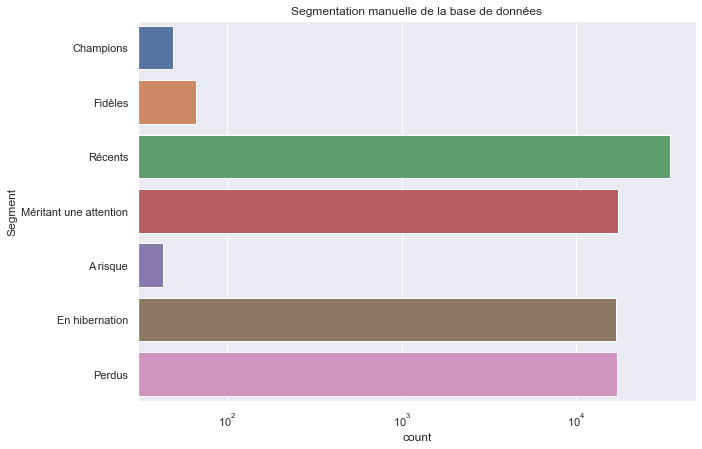

In [126]:
# Visualisation des segments
sns.set(rc={'figure.figsize':(10,7)})
g=sns.countplot(data = df_rfm, y = 'Segment', 
              order = segment)
g.set_xscale('log')
g.set(title='Segmentation manuelle de la base de données');

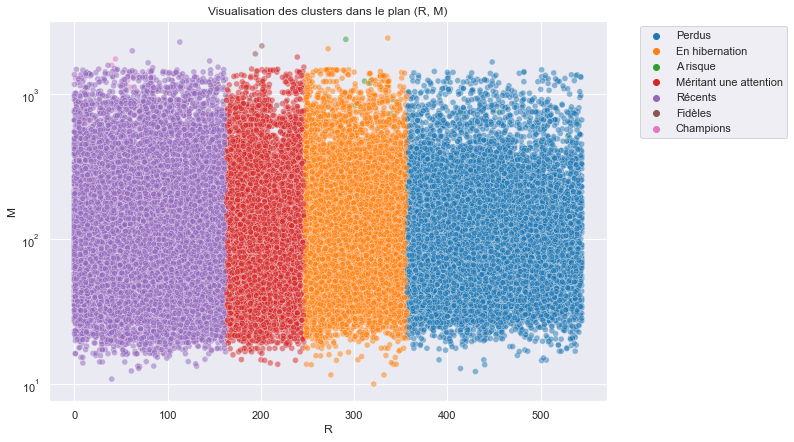

In [127]:
sns.set(rc={'figure.figsize':(10,7)})
g=sns.scatterplot(data = df_rfm, x='R', y='M', hue='Segment', hue_order = segment[::-1], palette ='tab10',alpha = 0.5)
g.set_yscale('log')
g.set(title='Visualisation des clusters dans le plan (R, M)');
plt.legend(bbox_to_anchor=(1.05, 1));

Distribution des variables RFM

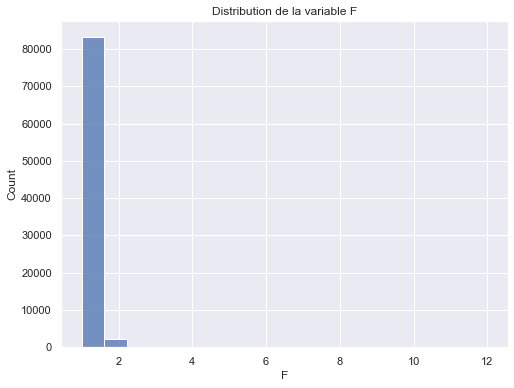

In [128]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='F')
g.set(title='Distribution de la variable F');

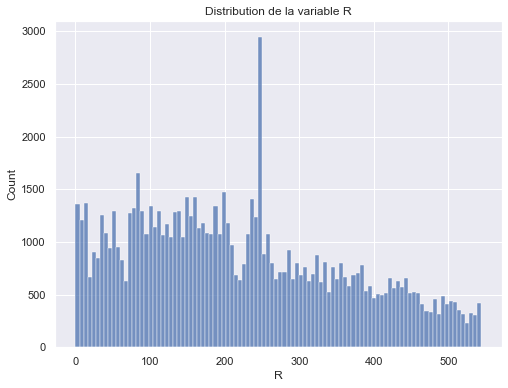

In [129]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='R', bins=100)
g.set(title='Distribution de la variable R');

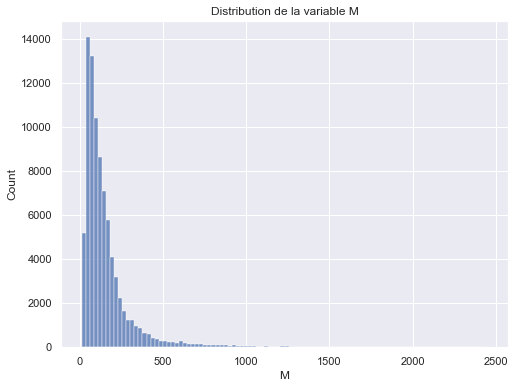

In [130]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='M', bins = 100)
g.set(title='Distribution de la variable M');

## Feature Engineering pour clustering automatique

In [131]:
# Création de la variable 'review_score' 
df_orders = df_orders.merge(df_order_reviews[['order_id','review_score']].groupby(by='order_id', as_index=False).median(), on='order_id',how='left')

In [132]:
# Ajout de cette variable au dataset df_rfm (médiane des notes de chaque client)
data = df_orders[['customer_unique_id','review_score']].groupby(by='customer_unique_id',as_index=False).median()
df_rfm = df_rfm.merge(data, on='customer_unique_id', how='left').rename(columns={'Segment':'Segment RFM'})

In [133]:
# Création de la variable 'delivery'
df_orders['delivered_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'].str.split(' ',expand=True)[0])
df_orders['estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'].str.split(' ',expand=True)[0])
df_orders['Delivery']=(df_orders['delivered_date']-df_orders['estimated_delivery_date']).dt.days

In [134]:
# Ajout de cette variable au dataset df_rfm (médiane des notes de chaque client)
data = df_orders[['customer_unique_id','Delivery']].groupby(by='customer_unique_id',as_index=False).median()
df_rfm = df_rfm.merge(data, on='customer_unique_id', how='left')

In [135]:
# Création de la variable 'purchased items' et ajout au dataset df_rfm
data = df_order_items[['order_id','order_item_id']].groupby(by='order_id', as_index=False).max()
df_orders = df_orders.merge(data, on='order_id', how='left')

In [136]:
data = df_orders[['customer_unique_id','order_item_id']].groupby(by='customer_unique_id',as_index=False).sum()
df_rfm = df_rfm.merge(data, on='customer_unique_id', how='left').rename(columns={'order_item_id':'purchased_items'})

In [137]:
# Suppression des valeurs manquantes
df_rfm=df_rfm.dropna()

Visualisation des distributions des nouvelles variables

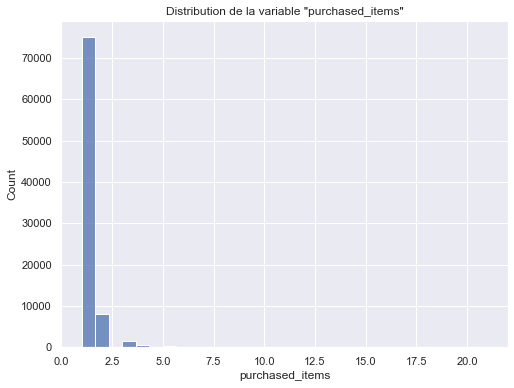

In [138]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='purchased_items',bins=30)
g.set(title='Distribution de la variable "purchased_items"');

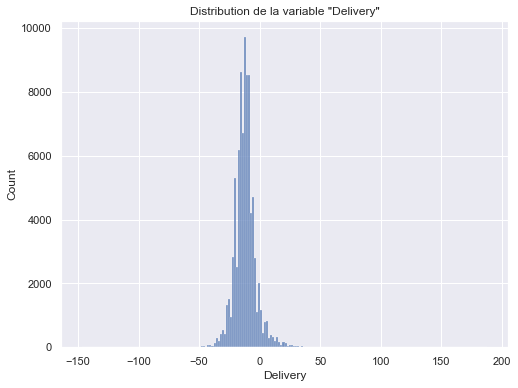

In [139]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='Delivery',bins=200)
g.set(title='Distribution de la variable "Delivery"');

In [140]:
# Suppression des outliers
df_rfm=df_rfm[df_rfm['Delivery']<50]
df_rfm=df_rfm[df_rfm['Delivery']>-50]

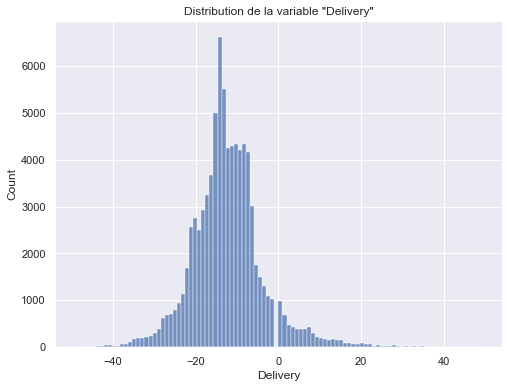

In [141]:
sns.set(rc={'figure.figsize':(8,6)})
g=sns.histplot(data = df_rfm, x='Delivery',bins=100)
g.set(title='Distribution de la variable "Delivery"');

In [142]:
df_rfm.describe()

,R,F,M,Score R,Score FM,review_score,Delivery,purchased_items
count,85651.000000,85651.000000,85651.000000,85651.000000,85651.000000,85651.000000,85651.000000,85651.000000
mean,220.076578,1.033041,156.241560,3.008733,2.015610,4.132541,-12.003357,1.178247
std,141.006938,0.205542,167.652826,1.413716,0.729118,1.296000,9.055252,0.600930
min,0.000000,1.000000,10.070000,1.000000,1.000000,1.000000,-49.000000,1.000000
25%,104.000000,1.000000,63.040000,2.000000,1.500000,4.000000,-17.000000,1.000000
50%,201.000000,1.000000,107.550000,3.000000,2.000000,5.000000,-13.000000,1.000000
75%,322.000000,1.000000,180.750000,4.000000,2.500000,5.000000,-8.000000,1.000000
max,544.000000,12.000000,2450.100000,5.000000,5.000000,5.000000,49.000000,21.000000


In [74]:
# Enregistrement des datasets pré-traités
df_rfm.to_csv(r"C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 5 - Segmentez des clients d'un site e-commerce\df_rfm.csv")
df_orders.to_csv(r"C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 5 - Segmentez des clients d'un site e-commerce\df_orders.csv")